**Deep Learning (COSC2779)  Assignment 1**

Salina Bharthu (S3736867)


Aim:
The aim of this assignment is to develope a deep convolutional neural network(CNN) to identify the head pose given an image of a person.

This Notebook outlines the implementation of deep CNN Model for the classification of pan angles of images. The tilt angles classification model is implemented in other notebook. The analysis and approach is discussed in report.


In [ ]:
# set this to print all output from a cell in notebook, not just the most recent one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings # suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
#Import useful packages
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix

#**Data Extraction and Exploration**

Dataset: 
The Dataset contains images of headpose captured from the camera placed on front. The headpose is quantified in two different labels, that are, tilt(vertical angle of the head) and pan(horizontal angle of the head). 
The images are of size 144*195 and are having labels of pan assigned in seperate csv data files.  


In [ ]:
#Connecting with Google drive for data extraction
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp /content/drive/'My Drive'/'Colab Notebooks'/modified_data.zip .
!unzip -q -o modified_data.zip -d Imagedata
!rm modified_data.zip

In [ ]:
#Extracting csv file containing metadata about images
data = pd.read_csv("../content/drive/My Drive/Colab Notebooks/train_data.csv")
testdata = pd.read_csv("../content/drive/My Drive/Colab Notebooks/test_data.csv")
data.head()
testdata.head()

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


In [ ]:
print("Data frame Size:", len(data) ,"\n")
print("Pan Labels:")
data.pan.unique()
data["pan"] = data["pan"].astype(str)

print("\n\nPerson_id Distribution in training dataframe")
data.person_id.value_counts()

print("\n\nSeries Distribution in training dataframe")
data.series.value_counts()

Data frame Size: 2325 

Pan Labels:


array([ 30, -75, -60, -90,  60, -15, -45, -30,  90,  15,  45,   0,  75])



Person_id Distribution in training dataframe


15    186
13    186
11    186
9     186
7     186
5     186
14    186
12    186
10    186
8     186
6     186
4     186
3      93
Name: person_id, dtype: int64



Series Distribution in training dataframe


2    1209
1    1116
Name: series, dtype: int64

The training dataframe contain 2325 images of person_id 3 to 15 that is the images of 13 persons. The image data distribution among person_id and series_id is highly balanced. 
Here, person_id can be the differentiating factor as the ultimate goal is to develope the model that can predict the headpose of the unknown person.

Text(0.5, 1.0, 'pan')

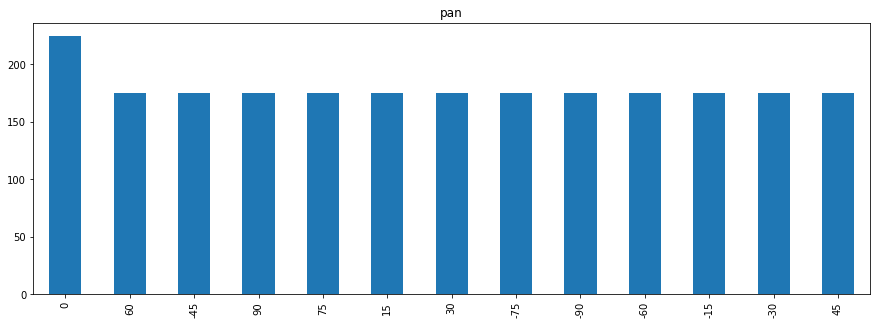

In [ ]:
#Plotting the Distribution of target labels
categorical_features = ["pan"]
fig = plt.figure(figsize=(10,10))
for i, categorical_feature in enumerate(data[categorical_features]):
    data[categorical_feature].value_counts().plot(kind = "bar", figsize = (15,5)).set_title(categorical_feature)
fig.show()

Above plot shows that the different pan angle classes are well balanced

<Figure size 1440x1440 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -15')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 90')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -60')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -90')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 30')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 60')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 0')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -45')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -30')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 75')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 15')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: 45')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'Tilt: -75')

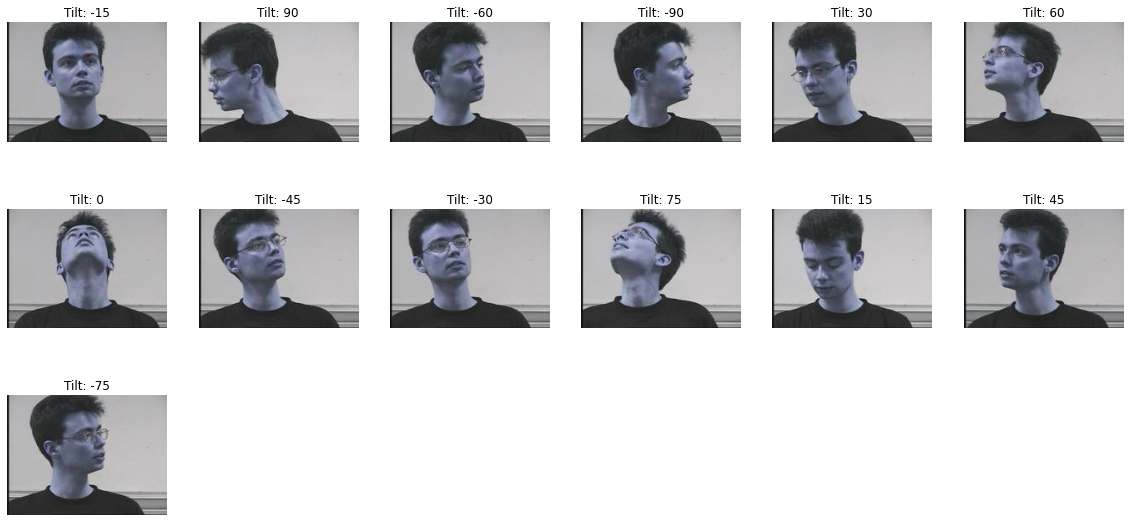

In [ ]:
#Extract image for each Label of Tilt Angle

tilt_label = set(data['pan'])
plt.figure(figsize=(20, 20))
i = 1 #counter
path = "/content/Imagedata/modified_data/"

for label in tilt_label:
    fullpath = path + data.loc[list(data['pan']).index(label)][0] #path to first image of each label
    image = cv2.imread(fullpath)
    plt.subplot(6, 6, i)
    plt.axis('off')
    plt.title("Tilt: {0}".format(label, list(data['tilt']).count(label)))
    i += 1
    plt.imshow(image, cmap="gray")

plt.show()

In [ ]:
print("Test Data size:", len(testdata), "\n")
print("Person_Id:")
testdata.person_id.unique()
print("\nSeries_Id:")
testdata.series.unique()

Test Data size: 465 

Person_Id:


array([2, 3, 1])


Series_Id:


array([1, 2])

#**Pan Classification Model Implementation**

**Data Preparation**


*   Initially, the train and test dataframes are seprated using person_id. The train dataframe is further splitted into train-validation datasets of 80-20 ratio.
*   While splitting the train and validation data, stratify is used on the target column in-order to ensure equalt distribution of  images from all classes.

*   The train and validation dataframe is further used to extract training and validation images using filenaes. This is implemented using keras ImageDataGenerator at runtime.  
*   The images are extracted using target_size of 100*100, which is finalized after experimenting with different sizes












In [ ]:
#Splitting out train-validation and test dataset
train_df  = data.loc[data['person_id'] < 13]
test_df = data.loc[data['person_id'] >= 13]

train_df.pan.unique() #Checking for all unique labels after split

train_df_pan, val_df_pan = train_test_split(train_df, test_size= 0.2, stratify = train_df['pan'], random_state = 22)

array(['30', '-75', '-60', '-90', '60', '-15', '-45', '-30', '90', '15',
       '45', '0', '75'], dtype=object)

In [ ]:
path = "/content/Imagedata/modified_data"
BATCH_SIZE = 16

#Training dataset preparation
def pan_train_generator():
    datagen = ImageDataGenerator(data_format='channels_last', rescale=1./255)
    pan_train_generator = datagen.flow_from_dataframe(
        dataframe = train_df_pan,
        directory = path,
        x_col = "filename",
        y_col = "pan",
        target_size = (100, 100),
        batch_size = 1,
        color_mode = "grayscale",
        shuffle = False,
        class_mode = 'categorical')
    return pan_train_generator

#Validation Dataset Preparation
def pan_val_generator():
    datagen = ImageDataGenerator(data_format='channels_last', rescale=1./255)
    pan_val_generator = datagen.flow_from_dataframe(
        dataframe = val_df_pan,
        directory = path,
        x_col = "filename",
        y_col = "pan",
        target_size = (100, 100),
        batch_size = 1,
        color_mode = "grayscale",
        shuffle = False,
        class_mode = 'categorical')
    return pan_val_generator

train_dataset_pan = tf.data.Dataset.from_generator(pan_train_generator, output_types=(tf.float32, tf.float32), output_shapes=([1,100,100,1], [1,13]))
vaidation_dataset_pan = tf.data.Dataset.from_generator(pan_val_generator,output_types=(tf.float32, tf.float32), output_shapes=([1,100,100,1], [1,13]))

VAL_LEN_PAN = val_df_pan.shape[0]
TRAIN_LEN_PAN = train_df_pan.shape[0]

In [ ]:
#Functions for Image Data pre-processing and Augmentation

AUTOTUNE = tf.data.experimental.AUTOTUNE

def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image[0,:]
  label = label[0,:]
  return image, label

def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 110, 110) # Add 10 pixels of padding
  image = tf.image.random_brightness(image, max_delta=0.3) # Random brightness
  image = tf.image.random_crop(image, size=[100, 100, 1]) # crop back to 100*100
  return image,label

In [ ]:
#Augmented Training Dataset Preparation
augmented_train_batches_pan = train_dataset_pan.take(TRAIN_LEN_PAN).cache()
augmented_train_batches_pan = augmented_train_batches_pan.shuffle(TRAIN_LEN_PAN).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
#Non Augmented Training Dataset Preparation
non_augmented_train_batches_pan = train_dataset_pan.take(TRAIN_LEN_PAN).cache()
non_augmented_train_batches_pan = non_augmented_train_batches_pan.shuffle(TRAIN_LEN_PAN).map(convert, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
#Validation Dataset Preparation
validation_batches_pan = vaidation_dataset_pan.take(VAL_LEN_PAN).cache()
validation_batches_pan =validation_batches_pan.map(convert, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True)

##**CNN Model Implementation**

**Baseline CNN Model Architecture**


*   Initially, developing very basic CNN model for dry run with 2 convolutional layers followed by max pooling layers and one dense layer with 64 units and outoput layer with 13 units for classification of 13 pan angles
*   The image with input size of 100*100 with depth = 1 (grayscale images) are given as an input to the Convolutional layers
*   Using 'relu' activation for adding non-linearity and 'adam' optimizer for faster convergence and adaptive learning rate
*   Training the base model on Augmented and Non-augmented Datasets with 50 epochs
*   Using categorical_crossentropy and accuracy metrics to evaluate the model performance



In [ ]:
# Function to create Neural Network Model
def base_model_nn(num_label):
    
    classifier = Sequential()
    
    # Input layer
    classifier.add(Input(shape=(100, 100, 1)))

    # Conv Layer 1
    classifier.add(Conv2D(16, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Layer 2 (no pooling)
    classifier.add(Conv2D(32, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    #Fully Connected layer
    classifier.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    classifier.add(Dense(64, activation='relu'))

    #output layer
    classifier.add(Dense(num_label, activation='softmax'))    
    classifier.summary()
    
    return classifier

**Base Model Run**

In [ ]:
UNIQUE_PAN = len(set(train_df_pan['pan']))
base_histories = {}
base_model_pan = base_model_nn(UNIQUE_PAN)  
base_model_pan.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=[tf.losses.CategoricalCrossentropy(name='CategoricalCrossentropy'), 'accuracy'])

#On Non Augmented Data
base_histories['Basemodel_Without_Aug_pan'] = base_model_pan.fit(non_augmented_train_batches_pan, epochs=50, validation_data=validation_batches_pan, verbose=1, batch_size = BATCH_SIZE)

#On Augmented Data
base_histories['Basemodel_With_Aug_pan'] = base_model_pan.fit(augmented_train_batches_pan, epochs=50, validation_data=validation_batches_pan, verbose=1, batch_size = BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1083456   
_________________________________________________________________
dense_1 (Dense)              (None, 13)                8

In [ ]:
#Function to plot training and validation curves
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 2.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

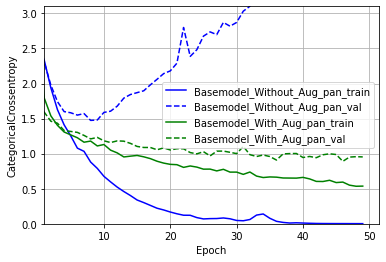

In [ ]:
plotter(base_histories, ylim=[0.0, 3.1], metric = 'CategoricalCrossentropy')

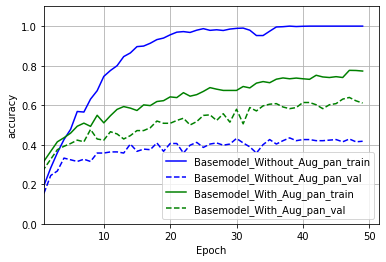

In [ ]:
plotter(base_histories, ylim=[0.0, 1.1], metric = 'accuracy')



*   Above learning and validation curves shows very high generalization gap while using non augmented training data batches. Therefore, the augmented data batches are used for further implementation
*   Also, there is a generalization gap depicting overfitting of data in Augmented training bvatches as well. This is addressed by modifying the CNN architecture.








**CNN Model Architecture Modifications**

*   L2 Kernel regularizer is added to Convolution layer to deal with overfitting . In this task, L2 regularizer adds small penalty value to the weights matrix of the nodes. Initially 0.001 regularization coefficient value is use which is optimized to obtain well-fitted model

*   In fully connected layers, dropout layer is added to deal with overfitting. It zero out the activation of randomly chosen nuerons as per the dropout rate. The dropout rate is initially chosen as 0.5 and further optimized.

*   Batch normalization layer is added to normalize tha mini batches. In this task, we can see the fluctuations in learning curve, the batch normalization can stabilize the learning process and reduce the number of epochs required by helping in fast convergence. The initial momentum for this is 0.75 and further optimized. 


*   To enhance the accuracy, 2 (Convolution + max pooling) layers are added. The filter size of the layers near the input layer is small and incremently changing in later layers.

*   Fully connected layers are configured to be added based upon the unit size passed. The number of nuerons are optimized later. 

*   The 'adam' optimizer is used with decaying learnng rate at run time. The adam optimizer itself uses adaptive learning rate to update the weights of each parameter, however, using exponential decay helps to speed up the optimization process.

* Here, the evaluation metrics precision and recall are added to gain better understanding of multi class classification   

In [ ]:
def get_cnn_model(num_label, STEPS_PER_EPOCH, filters = 8, kernel_size = 3, pool_size = 2, lambda_reg = 0.01, dropout = 0.5, units = 64, initial_lr= 0.001, momentum = 0.75):
  classifier = Sequential()

  # input
  classifier.add(Input(shape=(100, 100, 1)))

  # Conv Layer 1
  classifier.add(Conv2D(filters, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg)))
  classifier.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  # Conv Layer 2 (no pooling)
  classifier.add(Conv2D(filters*2, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lambda_reg)))
  classifier.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
  classifier.add(BatchNormalization(momentum = momentum, epsilon=0.001))

  # Conv Layer 3
  classifier.add(Conv2D(filters*4, (kernel_size, kernel_size), activation='relu', padding='same'))
  classifier.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  #Conv layer 4
  classifier.add(Conv2D(filters*4, (kernel_size, kernel_size), activation='relu', padding='same'))
  classifier.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
  classifier.add(Dropout(0.1))

  # MLP
  classifier.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  
  #Dense layer addition based on number of units
  while units > 64:
    classifier.add(Dense(units, activation='relu'))
    units = units/2
    
  classifier.add(Dropout(dropout))
  classifier.add(Dense(64, activation='relu'))
  classifier.add(Dense(num_label, activation='softmax'))
  
  #STEPS_PER_EPOCH = TRAIN_LEN_PAN//BATCH_SIZE
  #learning rate decay for adam optimizer
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_lr, decay_steps=STEPS_PER_EPOCH*1000, decay_rate=1, staircase=False)

  classifier.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=[tf.losses.CategoricalCrossentropy(name = 'CategoricalCrossentropy'), 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  classifier.save_weights('modelCNN.h5')
  classifier.summary()
  
  return classifier


**CNN Model Architecture before hyper parameter tuning**

In this architecture, the configurable parameters are selected based on few experiments, type of image data and baseline model results. These parameters are further tuned. 

In [ ]:
model_pan = get_cnn_model(UNIQUE_PAN, TRAIN_LEN_PAN)   

model_histories = {} #To store the model results


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 16)        1168      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 25, 16)        64        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)       

Initial run of CNN model on Augmented training data batches with 100 epochs

In [ ]:
#Fit the model on Augmented training data set
model_histories['With_augmentation_Pan'] = model_pan.fit(augmented_train_batches_pan, epochs=100, validation_data=validation_batches_pan, verbose=1)

Epoch 1/100
88/88 [==============================] - 9s 102ms/step - loss: 2.6391 - CategoricalCrossentropy: 2.5679 - accuracy: 0.0874 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5992 - val_CategoricalCrossentropy: 2.5628 - val_accuracy: 0.0966 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
88/88 [==============================] - 9s 100ms/step - loss: 2.5879 - CategoricalCrossentropy: 2.5648 - accuracy: 0.0987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5759 - val_CategoricalCrossentropy: 2.5614 - val_accuracy: 0.0966 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
88/88 [==============================] - 9s 101ms/step - loss: 2.5705 - CategoricalCrossentropy: 2.5595 - accuracy: 0.1001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5537 - val_CategoricalCrossentropy: 2.5449 - val_accuracy: 0.1733 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
88/88 [==============================] - 9s 102ms

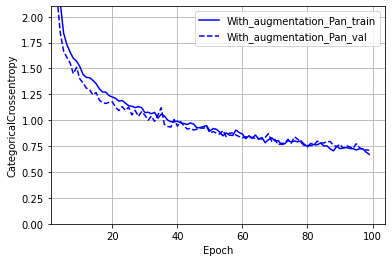

In [ ]:
#Training and Validation Plot for loss
plotter(model_histories, ylim=[0.0, 2.1], metric = 'CategoricalCrossentropy')

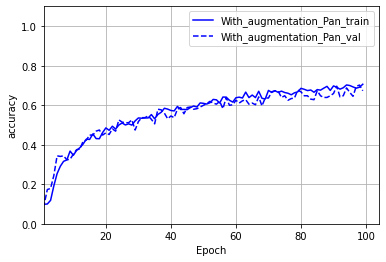

In [ ]:
#Training and Validation Plot for accuracy 
plotter(model_histories, ylim=[0.0, 1.1], metric = 'accuracy')

The above training and validation curves needs to be stabilized further. Therefore, training the model with 150 epochs

In [ ]:
#Fit the model on Augmented training data set
model_histories_epochs ={}
model_histories_epochs['With_augmentation_Pan'] = model_pan.fit(augmented_train_batches_pan, epochs=150, validation_data=validation_batches_pan, verbose=1)

Epoch 1/150
88/88 [==============================] - 9s 107ms/step - loss: 2.7050 - CategoricalCrossentropy: 2.5869 - accuracy: 0.0852 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 2.6601 - val_CategoricalCrossentropy: 2.5520 - val_accuracy: 0.1080 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/150
88/88 [==============================] - 9s 103ms/step - loss: 2.6317 - CategoricalCrossentropy: 2.5326 - accuracy: 0.1065 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 2.5131 - val_CategoricalCrossentropy: 2.4227 - val_accuracy: 0.1619 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/150
88/88 [==============================] - 9s 103ms/step - loss: 2.4040 - CategoricalCrossentropy: 2.3202 - accuracy: 0.1747 - precision_2: 0.2727 - recall_2: 0.0021 - val_loss: 2.1575 - val_CategoricalCrossentropy: 2.0797 - val_accuracy: 0.2017 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/150
88/88 [==========================

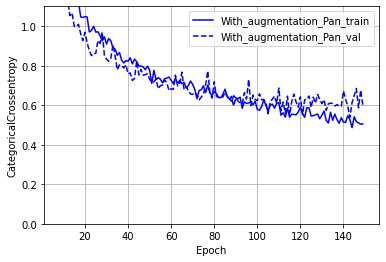

In [ ]:
plotter(model_histories_epochs, ylim=[0.0, 1.1], metric = 'CategoricalCrossentropy')

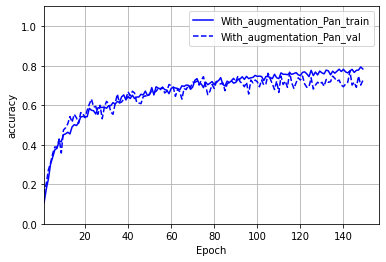

In [ ]:
plotter(model_histories_epochs, ylim=[0.0, 1.1], metric = 'accuracy')

The generalization gap seems to be increasing after 100 epochs showing minor overfitting. Therefore, the model training will be implemented using 100 epochs.

#**Hyper Parameter Tuning of CNN**

Below table shows the hyper parameters used for tuning and its significance

To enhance the performace of the model and reduce the generalization gap, parameter tuning is performed.

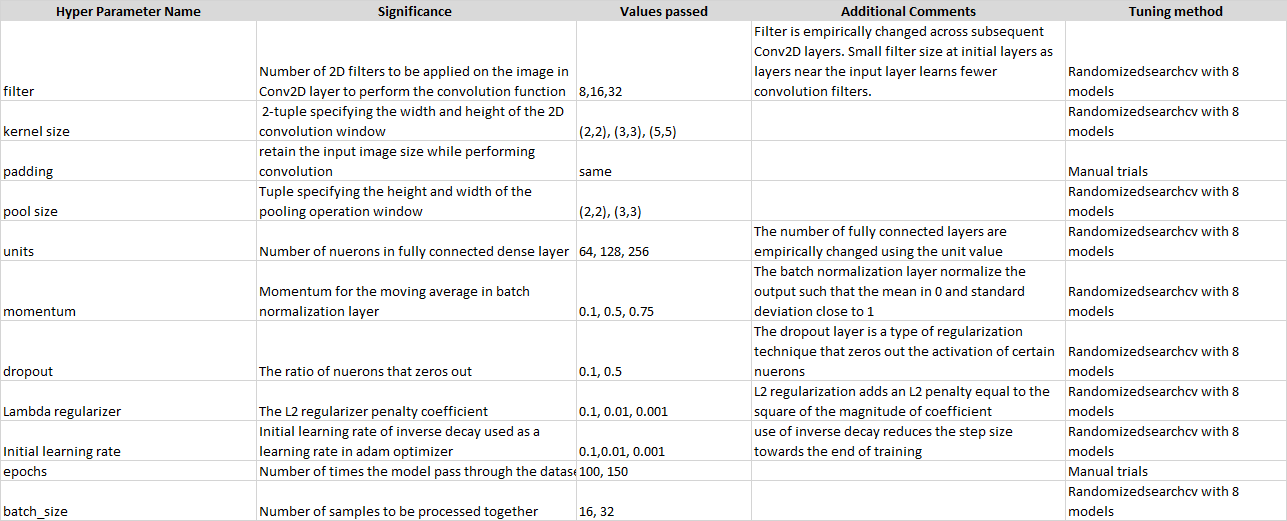

In [ ]:
pan_df = pan_train_generator()
X = np.concatenate([pan_df.next()[0] for i in range(TRAIN_LEN_PAN)])
y = np.concatenate([pan_df.next()[1] for i in range(TRAIN_LEN_PAN)])
print(X.shape)
print(y.shape)

Found 1413 validated image filenames belonging to 13 classes.
(1413, 100, 100, 1)
(1413, 13)


Warning: The below code block of parameter tuning takes very long time for execution. Due to the resource limitation, the hyper parameter tuning is performed on 50 epochs, whereas, the best results can be achieved using 100 epochs. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
STEPS_PER_EPOCH = TRAIN_LEN_PAN//BATCH_SIZE
model = KerasClassifier(build_fn = get_cnn_model, verbose = 1)
param_grid = dict(
    epochs = [50],
    initial_lr = [0.1, 0.01, 0.001],
    lambda_reg = [0.1, 0.01, 0.001],
    dropout = [0.3, 0.2, 0.5],
    kernel_size = [2,3],
    filters = [8, 16, 32],
    pool_size = [2,3],
    units = [64,128, 256],
    momentum = [0.5, 0.75, 0.1],
    num_label = [UNIQUE_PAN],
    STEPS_PER_EPOCH = [STEPS_PER_EPOCH]
  )

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv = 3, n_iter = 8)
grid_result = grid.fit(X_train, y_train, verbose = 0)

print("Best parameter set %s" % (grid_result.best_params_))

12/12 [==============================] - 1s 79ms/step - loss: 2.6253 - CategoricalCrossentropy: 2.5881 - accuracy: 0.0957 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00
Best parameter set {'units': 128, 'pool_size': 3, 'num_label': 13, 'momentum': 0.1, 'lambda_reg': 0.1, 'kernel_size': 3, 'initial_lr': 0.001, 'filters': 32, 'epochs': 50, 'dropout': 0.5, 'STEPS_PER_EPOCH': 88}


In [ ]:
grid_result.best_params_

{'STEPS_PER_EPOCH': 88,
 'dropout': 0.5,
 'epochs': 50,
 'filters': 32,
 'initial_lr': 0.001,
 'kernel_size': 3,
 'lambda_reg': 0.1,
 'momentum': 0.1,
 'num_label': 13,
 'pool_size': 3,
 'units': 128}

Now, Using best Param values to train the model

In [ ]:
model_tilt_tune = get_cnn_model(13, 88, 32, 3, 3, 0.1, 0.5, 128, 0.001, 0.1)
##num_label, STEPS_PER_EPOCH, filters = 8, kernel_size = 3, pool_size = 2, lambda_reg = 0.01, dropout = 0.5, units = 64, initial_lr= 0.001, momentum = 0.75
pan_histories = {}
pan_histories['With_Aug_Pan_tune'] = model_tilt_tune.fit(augmented_train_batches_pan, epochs=100, validation_data=validation_batches_pan, verbose=1)

Epoch 1/100
88/88 [==============================] - 32s 368ms/step - loss: 2.6338 - CategoricalCrossentropy: 2.5930 - accuracy: 0.0874 - precision_35: 0.0000e+00 - recall_35: 0.0000e+00 - val_loss: 2.5971 - val_CategoricalCrossentropy: 2.5613 - val_accuracy: 0.1023 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00
Epoch 2/100
88/88 [==============================] - 32s 362ms/step - loss: 2.6002 - CategoricalCrossentropy: 2.5691 - accuracy: 0.0930 - precision_35: 0.0000e+00 - recall_35: 0.0000e+00 - val_loss: 2.5896 - val_CategoricalCrossentropy: 2.5627 - val_accuracy: 0.0966 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00
Epoch 3/100
88/88 [==============================] - 32s 363ms/step - loss: 2.5383 - CategoricalCrossentropy: 2.5145 - accuracy: 0.1030 - precision_35: 0.0000e+00 - recall_35: 0.0000e+00 - val_loss: 2.2328 - val_CategoricalCrossentropy: 2.2115 - val_accuracy: 0.1847 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00
Epoch 4/100
88/88 [===

Learning and validation curve of model

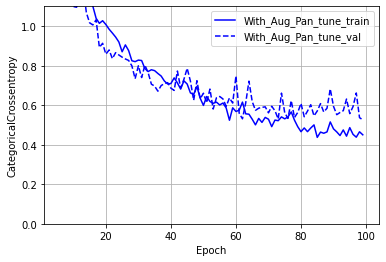

In [ ]:
plotter(pan_histories, ylim=[0.0, 1.1], metric = 'CategoricalCrossentropy')

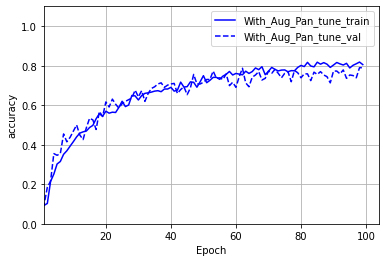

In [ ]:
plotter(pan_histories, ylim=[0.0, 1.1], metric = 'accuracy')

#Model Evaluation on Hold-out Test data

In [ ]:
#Creating dataset of holdout data
TEST_DF_LEN = test_df.shape[0]

test_datagen = ImageDataGenerator( data_format='channels_last', rescale=1./255 )
test_generator = test_datagen.flow_from_dataframe(
        dataframe = test_df, 
        directory = path,
        x_col = "filename",
        y_col = "pan",
        target_size = (100, 100),
        batch_size = 1,
        color_mode = "grayscale",
        shuffle = False,
        class_mode = 'categorical')

#Predicting labels on test data
pred = model_tilt_tune.predict(test_generator, verbose=1, steps=TEST_DF_LEN)
predicted_class_indices = np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

actual_labels = test_generator.classes
actual_test_labels = [labels2[k] for k in actual_labels]

Found 558 validated image filenames belonging to 13 classes.
558/558 [==============================] - 6s 10ms/step


In [ ]:
#Function to display classification report and confusion matrix
def displayConfusionMatrix(pred_y, test_lable, target_names):
    confusion_mat= confusion_matrix(test_lable, pred_y)
    print('Classification Report')
    print(classification_report(test_lable, pred_y, target_names=target_names))
    plt.imshow(confusion_mat, cmap=plt.cm.Greys)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion matrix of Hold out Test data')
    plt.colorbar()
    plt.show()

Classification Report
              precision    recall  f1-score   support

         -15       0.67      0.62      0.64        45
          45       0.50      0.62      0.55        34
          90       0.76      0.58      0.66        55
         -30       0.43      0.47      0.45        38
          15       0.40      0.39      0.40        44
         -75       0.57      0.73      0.64        33
         -60       0.61      0.80      0.69        41
          60       0.52      0.55      0.54        40
           0       0.67      0.54      0.60        52
         -45       0.64      0.59      0.61        46
         -90       0.48      0.53      0.50        38
          30       0.26      0.42      0.32        26
          75       0.90      0.58      0.70        66

    accuracy                           0.57       558
   macro avg       0.57      0.57      0.56       558
weighted avg       0.60      0.57      0.58       558



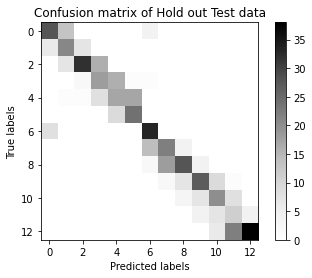

In [ ]:
target_names_pan = set(test_df['pan'])
displayConfusionMatrix(actual_test_labels, predictions, target_names_pan)

#**Prediction on unseen Data**

In [ ]:
#Preparing test dataset without labels, for pan angle prediction
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
final_test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdata,
    directory=path,
    x_col="filename",
    #y_col="",
    target_size=(100, 100),
    batch_size=1,
    color_mode="grayscale",
    shuffle=False,
    class_mode=None
)


Found 465 validated image filenames.


In [ ]:
pred_pan = model_tilt_tune.predict(final_test_generator, verbose=1, steps=len(final_test_generator))
test_predicted_pan_indices = np.argmax(pred_pan,axis=1)

final_test_predictions = [labels2[k] for k in test_predicted_pan_indices]

final_df = pd.DataFrame()
final_df['filename'] = testdata['filename']
final_df['pan'] = final_test_predictions
#print(predictions)

465/465 [==============================] - 5s 10ms/step


In [ ]:
final_df.head()

,filename,pan
0,face_33.jpg,0
1,face_2148.jpg,0
2,face_2119.jpg,30
3,face_1262.jpg,0
4,face_516.jpg,-75


In [ ]:
#Write Pan predictions to .csv file
final_df.to_csv('../content/drive/My Drive/Colab Notebooks/s3736867_pan.csv')